# Variational Dicke State Preparation

In [4]:
# Imports
import math
import cmath
%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy import linalg as la
from scipy import linalg as sla
from IPython.display import clear_output
import time
import pickle
from qiskit.extensions import XGate, UnitaryGate
from qiskit import *
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

provider = IBMQ.load_account()
from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info.synthesis import two_qubit_cnot_decompose as two_qubit_decomp

X = np.matrix([[0,1],[1,0]],dtype=complex)
Y = np.matrix([[0,-1j],[1j,0]],dtype=complex)

swap = np.array([[1,0,0,0],
                 [0,0,1,0],
                 [0,1,0,0],
                 [0,0,0,1]])

In [5]:
# Factor out global phase 
def factor_gp(psi): 
    gp = np.exp(1j*np.angle(psi[0]))
    psi[0] = np.absolute(psi[0])
    for i in range(1,len(psi)):
        psi[i] /= gp
        
    return psi

def get_phases(psi):
    n = len(psi)
    p_list = []
    for i in range(n):
        phi = np.angle(psi[i])
        if phi < 0:
            phi = 2*np.pi + phi
        p_list.append(phi/(2*np.pi))
        
    return(p_list)

def dict_sv(psi):
    n = len(psi)
    dic = {}
    for i in range(n):
        binary = str(np.binary_repr(i))
        binary = '0'*int(np.log2(n)-len(binary)) + binary
        dic[binary] = psi[i]*np.conj(psi[i])

    return dic

def dicts_sv(psi):
    n = len(psi)
    dics = []
    for i in range(n):
        dic = {}
        binary = str(np.binary_repr(i))
        binary = '0'*int(np.log2(n)-len(binary)) + binary
        dic[binary] = psi[i]*np.conj(psi[i])
        dics.append(dic)
        
    return dics

In [6]:
def pswap(theta):
    
    mat = np.array([[1,0,0,0],[0,np.cos(theta),-np.sin(theta),0],[0,np.sin(theta),np.cos(theta),0],[0,0,0,1]])
    
    return mat

In [7]:
#gets an array and shots for 4 qubits 
#then there are k numbers in theta 
def counts(theta,shots):
    
    q = QuantumRegister(4,'q')
    c = ClassicalRegister(4,'c')
    circ = QuantumCircuit(q,c)
    
    circ.h(q[0])
    circ.x(q[1])
    circ.cx(q[0],q[1])

    circ.cx(q[0],q[2])
    circ.cx(q[1],q[3])

    circ.append(two_qubit_decomp(pswap(theta[0])),[q[2],q[3]])
    circ.append(two_qubit_decomp(pswap(theta[1])),[q[1],q[2]])
    
#     circ.cz(q[2],q[3])
#     circ.cz(q[0],q[3])

    circ.cz(q[0],q[1])
    circ.cz(q[1],q[2])
    
    # Get statevector 
#     backend = BasicAer.get_backend('statevector_simulator')
#     result = execute(circ, backend).result()
#     psi = result.get_statevector()
#     psi = factor_gp(psi)
# #     print(psi)
#     phases = get_phases(psi)
#     color_map = mp.cm.get_cmap('plasma')
#     dic = dict_sv(psi)
#     plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
#     plt.show()
    
    trans = transpile(circ, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

#     return trans.draw(output='mpl')

    circ.measure(q,c)
    
    # Quantum device to simulate noise of
    backend = provider.get_backend('ibmq_santiago')

    # Noise Model
    noise_model = NoiseModel.from_backend(backend)
    coupling_map = backend.configuration().coupling_map
    basis_gates = noise_model.basis_gates

#     # Job from noisey simulation
#     job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)    
      
    # Regular job
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots=shots)    
    
    counts = job.result().get_counts(circ)
    
    return counts


In [ ]:
# counts([0,0,0,0],1)

In [8]:
def obj(theta,constants):
    
    shots = constants[0]
    num = constants[1]
    
    counts_dict_list = []
    for i in range(num):
        counts_dict_list.append(counts(theta,shots))
        
    keys = ['1100','1010','1001','0110','0101','0011']
        
    counts_avg = []
    for key in keys:
        c_list = []
        for i in range(num):
            if key in counts_dict_list[i].keys():
                c_list.append(counts_dict_list[i][key])
            else:
                c_list.append(0)
        counts_avg.append(np.average(c_list))

    return np.std(counts_avg)

In [ ]:
# shots = 6000
# num = 3
# n_theta = 2
# constants = [shots,num]

# theta = []
# for i in range(n_theta):
#     theta.append(np.random.uniform(0,2*np.pi))

# x_list = []
# def callback(x):
#     x_list.append(obj(x,constants))
#     itr = np.linspace(1,len(x_list),len(x_list))
#     plt.plot(itr,x_list)
#     clear_output(wait=True)
#     plt.show()

# opt = sp.optimize.minimize(obj, x0=theta, args=constants, method = 'Powell', callback=callback)

# theta_min = opt.x
# print(theta_min)

# counts_best = counts(theta_min, shots)
# print(counts_best)

# std_best = obj(theta_min,constants)
# print(std_best)

# plot_histogram(counts_best)

In [13]:
def counts_63(theta,shots):
    
    q = QuantumRegister(5,'q')
    c = ClassicalRegister(5,'c')
    circ = QuantumCircuit(q,c)
    
    circ.x(q[0])
    circ.x(q[2])
    
#     circ.ry(theta[5],q[0])
#     circ.x(q[1])
#     circ.cx(q[0],q[1])

#     circ.cx(q[0],q[2])
#     circ.cx(q[1],q[3])

#     circ.cx(q[0],q[4])
#     circ.cx(q[1],q[5])

    circ.append(two_qubit_decomp(pswap(theta[0]) @ swap),[q[0],q[1]])
    circ.append(two_qubit_decomp(pswap(theta[1]) @ swap),[q[2],q[3]])
    
    circ.append(two_qubit_decomp(pswap(theta[2]) @ swap),[q[1],q[2]])
    circ.append(two_qubit_decomp(pswap(theta[3]) @ swap),[q[3],q[4]])
    
    circ.append(two_qubit_decomp(pswap(theta[4]) @ swap),[q[0],q[1]])
    circ.append(two_qubit_decomp(pswap(theta[5]) @ swap),[q[2],q[3]])
    
    circ.append(two_qubit_decomp(pswap(theta[6]) @ swap),[q[1],q[2]])
    circ.append(two_qubit_decomp(pswap(theta[7]) @ swap),[q[3],q[4]])
    
#     circ.append(two_qubit_decomp(pswap(theta[2])),[q[4],q[5]])
    

    
#     circ.append(two_qubit_decomp(pswap(theta[5])),[q[0],q[1]])
#     circ.append(two_qubit_decomp(pswap(theta[6])),[q[2],q[3]])
#     circ.append(two_qubit_decomp(pswap(theta[7])),[q[4],q[5]])
    
#     # Get statevector 
#     backend = BasicAer.get_backend('statevector_simulator')
#     result = execute(circ, backend).result()
#     psi = result.get_statevector()
#     psi = factor_gp(psi)
#     print(psi)
#     phases = get_phases(psi)
#     color_map = mp.cm.get_cmap('plasma')
#     dic = dict_sv(psi)
#     plt.bar(dic.keys(), dic.values(), 0.5, color=color_map(phases))
#     plt.show()
    
#     trans = transpile(circ, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)

#     return circ.draw(output='mpl')

    circ.measure(q,c)
    
#     # Quantum device to simulate noise of
#     backend = provider.get_backend('ibmq_santiago')

#     # Noise Model
#     noise_model = NoiseModel.from_backend(backend)
#     coupling_map = backend.configuration().coupling_map
#     basis_gates = noise_model.basis_gates

#     # Job from noisey simulation
#     job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates, shots=shots)    
      
    # Regular job
    job = qiskit.execute(circ, Aer.get_backend('qasm_simulator'), shots=shots)    
    
    counts = job.result().get_counts(circ)
    
    return counts


In [14]:
counts_63([0,0,0,0,0,0,0,0],1)

{'11000': 1}

In [15]:
def obj_63(theta,constants):
    
    shots = constants[0]
    num = constants[1]
    
    counts_dict_list = []
    for i in range(num):
        counts_dict_list.append(counts_63(theta,shots))
        
    keys = ['11000','10100','10010','10001','01100','01010','01001','00110','00101','00011']
            
    counts_avg = []
    for key in keys:
        c_list = []
        for i in range(num):
            if key in counts_dict_list[i].keys():
                c_list.append(counts_dict_list[i][key])
            else:
                c_list.append(0)
        counts_avg.append(np.average(c_list))

    return np.std(counts_avg)

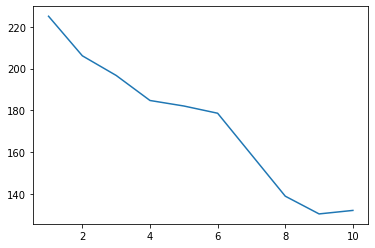

[2.92919065 1.96684151 5.57135755 2.22005046 2.43965674 3.56840431
 2.67682985 2.5316293 ]
{'10001': 342, '00011': 383, '01001': 617, '10010': 464, '00101': 417, '11000': 108, '00110': 544, '01010': 455, '10100': 433, '01100': 237}
132.7498901443362


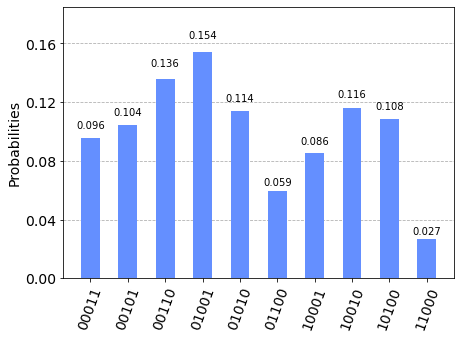

In [18]:
shots = 4000
num = 3
n_theta = 8
constants = [shots,num]

theta = []
for i in range(n_theta):
    theta.append(np.random.uniform(0,2*np.pi))

x_list = []
def callback(x):
    x_list.append(obj_63(x,constants))
    itr = np.linspace(1,len(x_list),len(x_list))
    plt.plot(itr,x_list)
    clear_output(wait=True)
    plt.show()

opt = sp.optimize.minimize(obj_63, x0=theta, args=constants, method = 'Powell', callback=callback)

theta_min = opt.x
print(theta_min)

counts_best = counts_63(theta_min, shots)
print(counts_best)

std_best = obj_63(theta_min,constants)
print(std_best)

plot_histogram(counts_best)